In [ ]:
# step 0 installs
%pip install transformers torch pandas numpy matplotlib networkx seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
# step 0 imports
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
import seaborn as sns

In [21]:
# Step 1: Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
# Step 2: Define masked embedding function
def get_masked_embedding(sequence, max_nt=1000):
    sequence = sequence[:max_nt]
    tokens = tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=tokenizer.model_max_length)
    input_ids = tokens["input_ids"]
    attention_mask = input_ids != tokenizer.pad_token_id

    with torch.no_grad():
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            encoder_attention_mask=attention_mask,
            output_hidden_states=True
        )
    embeddings = outputs.hidden_states[-1]
    attention_mask = attention_mask.unsqueeze(-1)
    masked_embeddings = embeddings * attention_mask
    mean_embedding = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1)
    return mean_embedding.squeeze().numpy()


In [23]:
# Step 3: Define original sequences
df_8325 = pd.DataFrame([
    {"Header": "Strain 1", "Sequence": "ATTCCGATTCCGATTCCG"},
    {"Header": "Strain 2", "Sequence": "ATTTCTCTCTCTCTCTGAGATCGATCGATCGAT"},
    {"Header": "Strain 3", "Sequence": "GCGTATCGATCGATCGATCGATCGATCGATCGT"}
])

# Step 4: Define reference sequences
df_ref = pd.DataFrame([
    {"Header": "Ref1", "Sequence": "TATATATATATATATATATATATATATATATA"},
    {"Header": "Ref2", "Sequence": "CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGC"}
])


In [24]:
# Step 5: Simulate mutated sequences
def mutate_sequence(seq, n_mutations=10):
    seq = list(seq)
    for _ in range(n_mutations):
        idx = random.randint(0, len(seq)-1)
        seq[idx] = random.choice(['A', 'T', 'C', 'G'])
    return ''.join(seq)

mutated_rows = []
for i in range(5):
    mutated_seq = mutate_sequence(df_8325.loc[0]['Sequence'], n_mutations=10)
    mutated_rows.append({
        'Header': f'Mutated_{i+1}',
        'Sequence': mutated_seq,
        'embedding': get_masked_embedding(mutated_seq)
    })

df_mut = pd.DataFrame(mutated_rows)


In [25]:
# Step 6: Generate embeddings for original and reference sequences
df_8325['embedding'] = df_8325['Sequence'].apply(get_masked_embedding)
df_ref['embedding'] = df_ref['Sequence'].apply(get_masked_embedding)

# Step 7: Combine all sequences
df_all = pd.concat([df_8325, df_ref, df_mut], ignore_index=True)


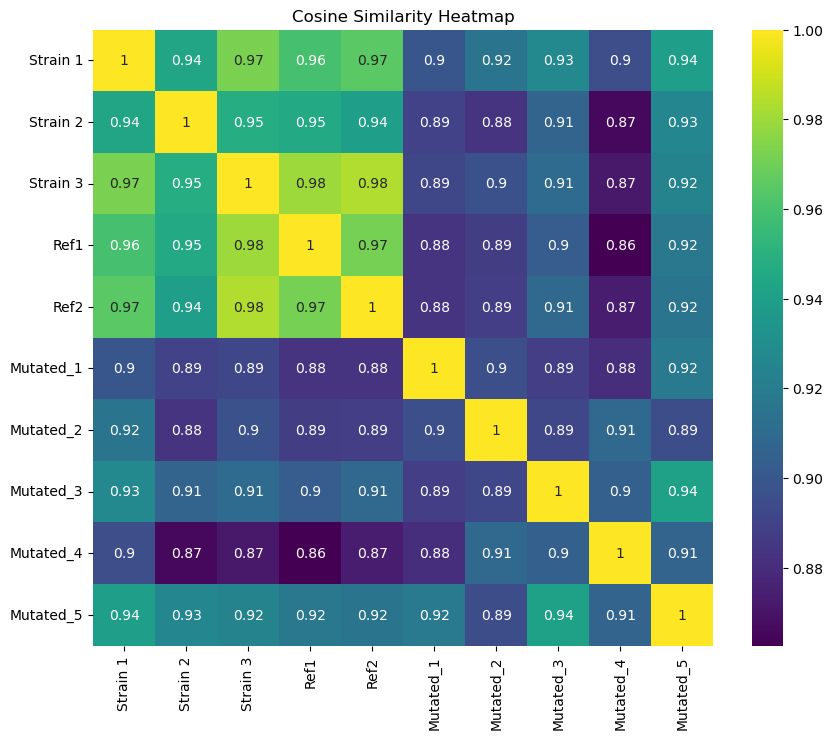

In [ ]:
# Step 8: Cosine similarity matrix
X = np.stack(df_all['embedding'].values)
similarity_matrix = cosine_similarity(X)

# Optional: Visualise similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=df_all['Header'], yticklabels=df_all['Header'], annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap")
plt.show()

# Step 9: Clustering with DBSCAN
clustering = DBSCAN(eps=0.1, min_samples=2, metric='cosine').fit(X)
df_all['Cluster'] = clustering.labels_


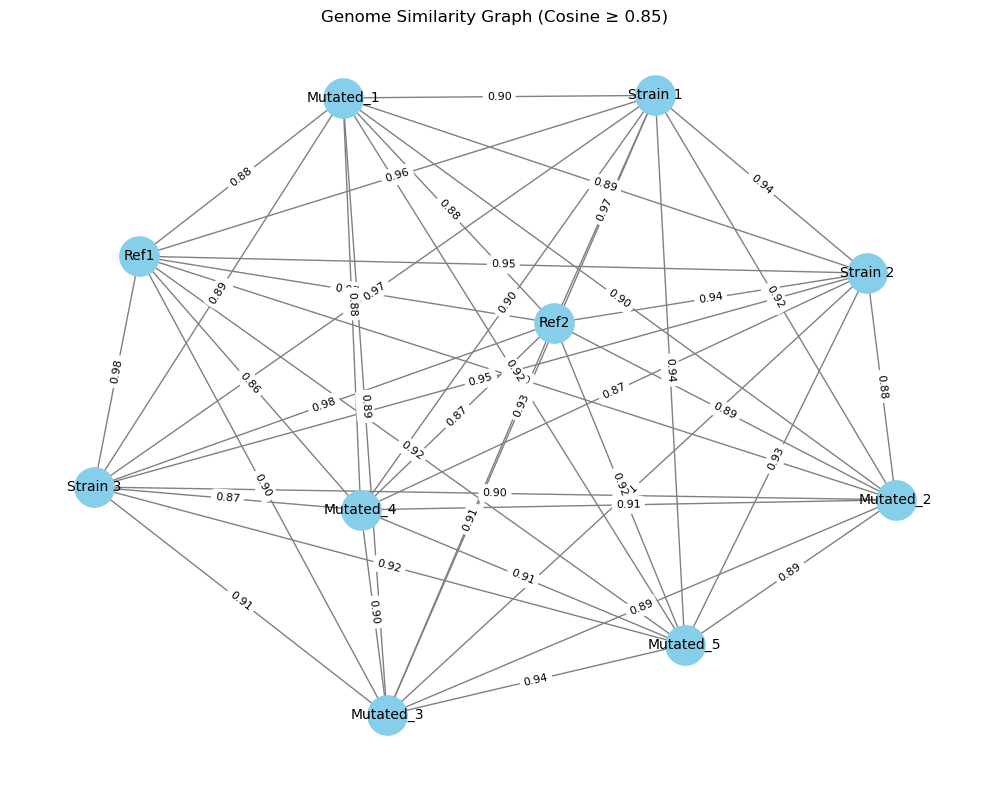

In [ ]:
# Step 10: Build similarity graph
threshold = 0.85  # adjust as needed
G = nx.Graph()
for i, label_i in enumerate(df_all['Header']):
    G.add_node(label_i)
    for j in range(i+1, len(df_all)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(label_i, df_all['Header'][j], weight=similarity_matrix[i][j])

# Step 11: Visualise similarity graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph (Cosine ≥ 0.85)")
plt.axis('off')
plt.tight_layout()
plt.show()

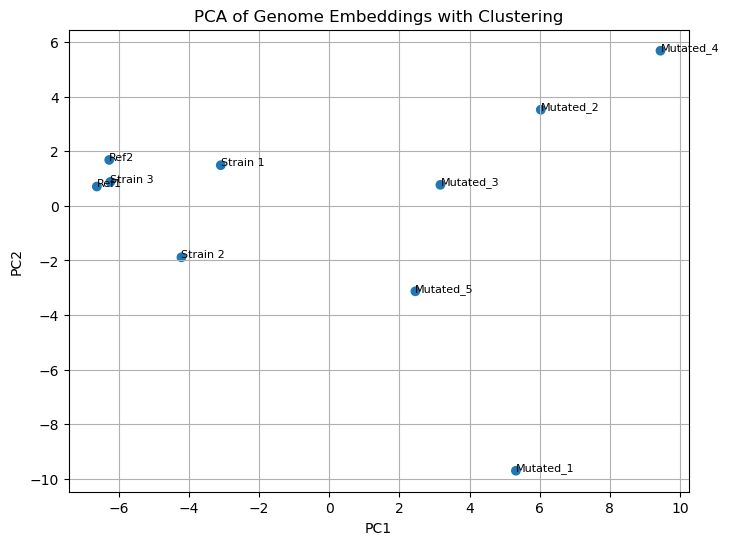

In [ ]:
# Step 12: PCA visualiaation with cluster coloring
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
jitter = np.random.normal(0, 0.01, X_pca.shape)
X_pca_jittered = X_pca + jitter

unique_clusters = sorted(df_all['Cluster'].unique())
color_map = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(unique_clusters)}
colors = [color_map[c] for c in df_all['Cluster']]

plt.figure(figsize=(8,6))
plt.scatter(X_pca_jittered[:,0], X_pca_jittered[:,1], c=colors)
for i, label in enumerate(df_all['Header']):
    plt.text(X_pca_jittered[i,0], X_pca_jittered[i,1], label, fontsize=8)
plt.title("PCA of Genome Embeddings with Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [29]:
# Step 13: SIR simulation (no intervention)
def simulate_sir(beta, gamma, S0=0.99, I0=0.01, R0=0.0, days=100):
    S, I, R = [S0], [I0], [R0]
    for _ in range(days):
        next_S = S[-1] - beta * S[-1] * I[-1]
        next_I = I[-1] + beta * S[-1] * I[-1] - gamma * I[-1]
        next_R = R[-1] + gamma * I[-1]
        S.append(next_S)
        I.append(next_I)
        R.append(next_R)
    return S, I, R

# Parameters: beta = transmission rate, gamma = recovery rate
beta_normal = 0.3
gamma = 0.1
days = 100

S1, I1, R1 = simulate_sir(beta_normal, gamma, days=days)



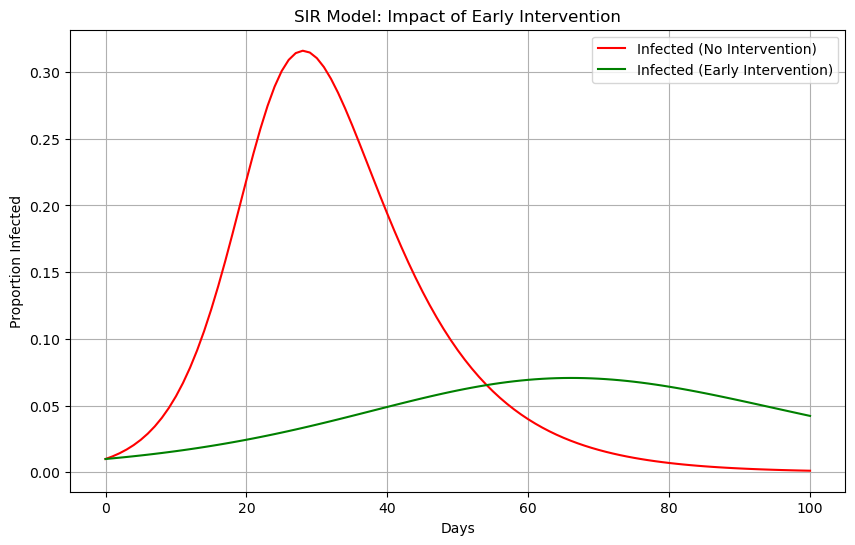

In [30]:
# Step 14: SIR simulation with early intervention
beta_intervention = 0.15  # reduced transmission due to early action
S2, I2, R2 = simulate_sir(beta_intervention, gamma, days=days)

# Plot both scenarios
plt.figure(figsize=(10,6))
plt.plot(I1, label="Infected (No Intervention)", color='red')
plt.plot(I2, label="Infected (Early Intervention)", color='green')
plt.xlabel("Days")
plt.ylabel("Proportion Infected")
plt.title("SIR Model: Impact of Early Intervention")
plt.legend()
plt.grid(True)
plt.show()